In [101]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Детерминированные алгоритмы
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender, TFIDFRecommender, BM25Recommender

# Метрики
from implicit.evaluation import train_test_split
# from implicit.evaluation import precision_at_k, mean_average_precision_at_k, AUC_at_k, ndcg_at_k
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('02_Data/retail_train.csv')
data.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [3]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

# 1. Бейзлайны

In [34]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns = ['user_id', 'actual']
result_det = result.copy() # заготовка для работы с детерминированными алгоритмами
result.head()

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."
3,7,"[840386, 889774, 898068, 909714, 929067, 95347..."
4,8,"[835098, 872137, 910439, 924610, 992977, 10412..."


In [5]:
test_users = result.shape[0]
new_test_users = len(set(data_test['user_id'].unique()) - set(data_train['user_id'].unique()))
print('В тестовом датасете {} юзеров'.format(test_users))
print('В тестовом датасете {} новых юзеров'.format(new_test_users))

В тестовом датасете 2042 юзеров
В тестовом датасете 0 новых юзеров


### Задание 1. Weighted Random Recommendation

Напишите код для случайных рекоммендаций, в которых вероятность рекомендовать товар прямо пропорциональна логарифму продаж
- Можно сэмплировать товары случайно, но пропорционально какому-либо весу
- Например, прямопропорционально популярности. Вес = log(sales_sum товара)

In [6]:
def weighted_random_recommendation(items_weights, n=5):
    """Случайные рекоммендации
    
    Input
    -----
    items_weights: pd.DataFrame
        Датафрейм со столбцами item_id, weight. Сумма weight по всем товарам = 1
    """
    
    # Подсказка: необходимо модифицировать функцию random_recommendation()
    # your_code
    recs = np.random.choice(items_weights['item_id'], size=n, replace=True, p=items_weights['weight'].tolist())
    
    return recs.tolist()

In [7]:
items_weights = data_train.groupby('item_id')['sales_value'].sum().reset_index()
items_weights.columns = ['item_id', 'weight']

items_weights = items_weights[items_weights['weight'] > 1]

items_weights['weight'] = np.log(items_weights['weight'])

items_weights['weight'] = items_weights['weight'] / items_weights['weight'].sum()

items_weights['weight'].describe()

count    8.225200e+04
mean     1.215776e-05
std      7.207094e-06
min      4.374495e-08
25%      6.094610e-06
50%      1.096096e-05
75%      1.719063e-05
max      5.720551e-05
Name: weight, dtype: float64

In [8]:
items_weights['weight'].sum()

1.0000000000000002

### Задание 2. Расчет метрик
Рассчитайте Precision@5 для каждого алгоритма с помощью функции из вебинара 1. Какой алгоритм показывает лучшее качество?

In [9]:
result_old = pd.read_csv('02_Data/predictions_basic.csv')
result_old.head(2)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases
0,1,[ 821867 834484 856942 865456 889248 ...,"[9270278, 842986, 6602381, 13115501, 940399]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 1029743, 995785, 1004906, 1081177]"
1,3,[ 835476 851057 872021 878302 879948 ...,"[1991359, 824156, 945901, 1808672, 1106390]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1098066, 995242, 826249]","[1082185, 1098066, 981760, 826249, 883404]","[1082185, 981760, 1098066, 826249, 883404]","[1082185, 1098066, 6534178, 1127831, 1068719]"


In [10]:
import re

# функция для распарсивания списков в считанном из csv-файла датафрейме
def data_parse(row):
    if row != '[]':
        return list(map(int, re.split(r'[\s|,]+', row.strip('[ ]'))))
    else:
        return list()

In [11]:
for col in result_old.columns[1:]:
    result_old[col] = result_old[col].apply(lambda x: data_parse(x))
    
result_old.head(2)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[9270278, 842986, 6602381, 13115501, 940399]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 1029743, 995785, 1004906, 1081177]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1991359, 824156, 945901, 1808672, 1106390]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1098066, 995242, 826249]","[1082185, 1098066, 981760, 826249, 883404]","[1082185, 981760, 1098066, 826249, 883404]","[1082185, 1098066, 6534178, 1127831, 1068719]"


In [12]:
%%time

# применяем к датафрейму написанную выше функцию "weighted_random_recommendation"
result_old['weighted_random_recommendation'] = result_old['user_id'].apply(lambda x: weighted_random_recommendation(items_weights, n=5))

columns = ['user_id', 'actual', 'random_recommendation', 'weighted_random_recommendation', 'popular_recommendation', 'itemitem', 'cosine', 'tfidf', 'own_purchases']
result_old = result_old[columns]
result_old.head()

CPU times: user 8.4 s, sys: 59.3 ms, total: 8.46 s
Wall time: 8.46 s


,user_id,actual,random_recommendation,weighted_random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[9270278, 842986, 6602381, 13115501, 940399]","[7442225, 2043153, 8015935, 849886, 13115659]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 1029743, 995785, 1004906, 1081177]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1991359, 824156, 945901, 1808672, 1106390]","[625183, 6545809, 9677305, 930502, 12731286]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1098066, 995242, 826249]","[1082185, 1098066, 981760, 826249, 883404]","[1082185, 981760, 1098066, 826249, 883404]","[1082185, 1098066, 6534178, 1127831, 1068719]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[9396714, 877208, 1130025, 985387, 15972849]","[1130302, 885697, 1096290, 992029, 991364]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 878996, 961554]","[1082185, 1029743, 6534178, 1127831, 995785]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[923997, 6701914, 1240019, 14025306, 991575]","[9858700, 12604182, 1023225, 873527, 10311347]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 961554, 1098066]","[1082185, 981760, 1127831, 961554, 826249]","[1082185, 1029743, 1127831, 995785, 1044078]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[832096, 947074, 402394, 7442760, 885261]","[1072900, 1127876, 897409, 13416117, 16223023]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 1098066, 995242]","[1082185, 981760, 1098066, 826249, 1127831]","[1082185, 981760, 1098066, 826249, 1127831]","[1082185, 1029743, 1098066, 6534178, 1127831]"


In [13]:
from my_metrics import precision_at_k, recall_at_k, ap_k, ndcg_at_k, reciprocal_rank

print('Recommendation algorithm\metrics│  Precision@5  │   Recall@5    │     AP@5      │    NDCG@5     │     RR@5      ')
for col in result_old.columns[1:]:
    print('────────────────────────────────┼───────────────┼───────────────┼───────────────┼───────────────┼───────────────')
    metric_1 = round(result_old.apply(lambda row: precision_at_k(row[col], row['actual'], k=5), axis=1).mean(),4)
    metric_2 = round(result_old.apply(lambda row: recall_at_k(row[col], row['actual'], k=5), axis=1).mean(),4)
    metric_3 = round(result_old.apply(lambda row: ap_k(row[col], row['actual'], k=5), axis=1).mean(),4)
    metric_4 = round(result_old.apply(lambda row: ndcg_at_k(row[col], row['actual'], k=5), axis=1).mean(),4)
    metric_5 = round(result_old.apply(lambda row: reciprocal_rank(row[col], row['actual'], k=5), axis=1).mean(),4)
    print(f'{col: <32}│{metric_1: ^15.4f}│{metric_2: ^15.4f}│{metric_3: ^15.4f}│{metric_4: ^15.4f}│{metric_5: ^15.4f}')

Recommendation algorithm\metrics│  Precision@5  │   Recall@5    │     AP@5      │    NDCG@5     │     RR@5      
────────────────────────────────┼───────────────┼───────────────┼───────────────┼───────────────┼───────────────
actual                          │    1.0000     │    0.2710     │    1.0000     │    1.0000     │    1.0000     
────────────────────────────────┼───────────────┼───────────────┼───────────────┼───────────────┼───────────────
random_recommendation           │    0.0003     │    0.0000     │    0.0009     │    0.0003     │    0.0009     
────────────────────────────────┼───────────────┼───────────────┼───────────────┼───────────────┼───────────────
weighted_random_recommendation  │    0.0018     │    0.0003     │    0.0046     │    0.0020     │    0.0046     
────────────────────────────────┼───────────────┼───────────────┼───────────────┼───────────────┼───────────────
popular_recommendation          │    0.1552     │    0.0250     │    0.2568     │    0.1596     

### Итог: По совокупности метрик TFIDFRecommender выдаёт лучшие результаты

### Задание 3*. Улучшение бейзлайнов и ItemItem

- Попробуйте улучшить бейзлайны, считая их на топ-5000 товаров
- Попробуйте улучшить разные варианты ItemItemRecommender, выбирая число соседей $K$.

In [15]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.head()

,item_id,quantity
0,25671,6
1,26081,1
2,26093,1
3,26190,1
4,26355,2


In [16]:
from math import log

top_5000 = popularity.sort_values('quantity', ascending=False).head(5000).sample(frac=1, replace=False, random_state=1234).reset_index(drop=True)
top_5000['weight'] = top_5000['quantity'].apply(lambda x: log(x))
top_5000.drop(columns='quantity', inplace=True)
total = top_5000['weight'].sum()
top_5000['weight'] = top_5000['weight'].apply(lambda x: x / total)
top_5000.head()

,item_id,weight
0,1043920,0.000189
1,835618,0.000192
2,1108092,0.000212
3,5567702,0.000206
4,13008314,0.000175


In [17]:
top_5000.shape

(5000, 2)

In [18]:
top_5000['weight'].sum()

0.9999999999999999

In [19]:
def random_recommendation(items, k=5):
    """Случайные рекоммендации"""
    
    items = np.array(items)
    recs = np.random.choice(items, size=k, replace=False)
    
    return recs.tolist()

In [20]:
result['random_recommendation'] = result['user_id'].apply(lambda x: random_recommendation(top_5000['item_id'], k=5))

In [21]:
def weighted_random_recommendation(top_5000, k=5):
    """Взвешенные случайные рекоммендации"""
    
    recs = np.random.choice(top_5000['item_id'], size=k, replace=True, p=top_5000['weight'].tolist())
    
    return recs.tolist()

In [22]:
result['weighted_random_recommendation'] = result['user_id'].apply(lambda x: weighted_random_recommendation(top_5000, k=5))

In [23]:
def popularity_recommendation(data, k=5):
    """Топ-n популярных товаров"""
    
    data.sort_values('weight', ascending=False, inplace=True)
    recs = data.head(k).item_id
    
    return recs.tolist()

In [24]:
popular_recs = popularity_recommendation(top_5000, k=5)

result['popular_recommendation'] = result['user_id'].apply(lambda x: popular_recs)

In [25]:
result.head()

,user_id,actual,random_recommendation,weighted_random_recommendation,popular_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[865330, 845675, 871876, 975155, 873550]","[1013999, 853235, 1045966, 1108654, 1055412]","[6534178, 6533889, 6534166, 6544236, 1404121]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[837644, 830156, 827667, 1075786, 891505]","[9526730, 1074241, 951746, 1125702, 882595]","[6534178, 6533889, 6534166, 6544236, 1404121]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1113274, 871097, 928555, 921345, 1095100]","[8177622, 1027372, 914346, 845307, 13095243]","[6534178, 6533889, 6534166, 6544236, 1404121]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[9802981, 1137694, 1120741, 1057260, 965331]","[10457044, 12518330, 1077975, 937626, 868645]","[6534178, 6533889, 6534166, 6544236, 1404121]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[928049, 957013, 8203710, 7025114, 9858947]","[1007210, 1021694, 5995603, 10121610, 958252]","[6534178, 6533889, 6534166, 6544236, 1404121]"


In [26]:
print('   Baseline-algorithm\metrics   │  Precision@5  │   Recall@5    │     AP@5      │    NDCG@5     │     RR@5      ')
for col in result.columns[2:]:
    print('────────────────────────────────┼───────────────┼───────────────┼───────────────┼───────────────┼───────────────')
    metric_1 = round(result.apply(lambda row: precision_at_k(row[col], row['actual'], k=5), axis=1).mean(),4)
    metric_2 = round(result.apply(lambda row: recall_at_k(row[col], row['actual'], k=5), axis=1).mean(),4)
    metric_3 = round(result.apply(lambda row: ap_k(row[col], row['actual'], k=5), axis=1).mean(),4)
    metric_4 = round(result.apply(lambda row: ndcg_at_k(row[col], row['actual'], k=5), axis=1).mean(),4)
    metric_5 = round(result.apply(lambda row: reciprocal_rank(row[col], row['actual'], k=5), axis=1).mean(),4)
    print(f'{col: <32}│{metric_1: ^15.4f}│{metric_2: ^15.4f}│{metric_3: ^15.4f}│{metric_4: ^15.4f}│{metric_5: ^15.4f}')

   Baseline-algorithm\metrics   │  Precision@5  │   Recall@5    │     AP@5      │    NDCG@5     │     RR@5      
────────────────────────────────┼───────────────┼───────────────┼───────────────┼───────────────┼───────────────
random_recommendation           │    0.0049     │    0.0004     │    0.0113     │    0.0049     │    0.0113     
────────────────────────────────┼───────────────┼───────────────┼───────────────┼───────────────┼───────────────
weighted_random_recommendation  │    0.0060     │    0.0006     │    0.0132     │    0.0059     │    0.0132     
────────────────────────────────┼───────────────┼───────────────┼───────────────┼───────────────┼───────────────
popular_recommendation          │    0.0461     │    0.0125     │    0.2057     │    0.0704     │    0.2064     


### Итог по первому подзаданию:
Значения метрик случайных рекомендаций возрасли незначительно (с детерминированными алгоритмами рекомендаций не конкурируют даже близко), при этом значения метрики для рекомендаций популярных товаров сильно просели (но сравнение на самом деле не корректное, т.к. на вебинаре сортировка выполнялась по суммам продаж товаров, а здесь по проданному количеству).

In [27]:
# Заведем фиктивный item_id (если юзер покупал товары не из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000['item_id']), 'item_id'] = 999999
data_train.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [30]:
%%time
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix[user_item_matrix > 0] = 1 # так как в итоге хотим предсказать 
user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат sparse matrix
sparse_user_item = csr_matrix(user_item_matrix)

CPU times: user 1.63 s, sys: 120 ms, total: 1.75 s
Wall time: 1.75 s


In [33]:
sparse_user_item.shape

(2499, 5001)

In [32]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [141]:
k_neighbors_list = [2, 3, 5, 7, 10, 15, 20, 25, 35, 50, 70, 100, 150]

recommender_alg = ['itemitem', 'cosine', 'tfidf']
precision_at_k_dict = dict((item, []) for item in recommender_alg)
recall_at_k_dict = dict((item, []) for item in recommender_alg)
ap_at_k_dict = dict((item, []) for item in recommender_alg)
ndcg_at_k_dict = dict((item, []) for item in recommender_alg)
rr_at_k_dict = dict((item, []) for item in recommender_alg)

# k = k_neighbors_list[2]
for k in k_neighbors_list:
    result_temp = result_det.copy()

    # fit
    model_1 = ItemItemRecommender(K=k, num_threads=4)
    model_1.fit(sparse_user_item.T, show_progress=False)

    model_2 = CosineRecommender(K=k, num_threads=4)
    model_2.fit(sparse_user_item.T, show_progress=False)

    model_3 = TFIDFRecommender(K=k, num_threads=4)
    model_3.fit(sparse_user_item.T, show_progress=False)

    # recommend
    result_temp['itemitem'] = result_temp['user_id'].apply(lambda x: [
        id_to_itemid[rec[0]] for rec in model_1.recommend(
            userid=userid_to_id[x], 
            user_items=sparse_user_item,   # на вход user-item matrix
            N=5, 
            filter_already_liked_items=False, 
            filter_items=[itemid_to_id[999999]], 
            recalculate_user=True
        )
    ])

    result_temp['cosine'] = result_temp['user_id'].apply(lambda x: [
        id_to_itemid[rec[0]] for rec in model_2.recommend(
            userid=userid_to_id[x], 
            user_items=sparse_user_item,   # на вход user-item matrix
            N=5, 
            filter_already_liked_items=False, 
            filter_items=[itemid_to_id[999999]], 
            recalculate_user=True
        )
    ])

    result_temp['tfidf'] = result_temp['user_id'].apply(lambda x: [
        id_to_itemid[rec[0]] for rec in model_3.recommend(
            userid=userid_to_id[x], 
            user_items=sparse_user_item,
            N=5, 
            filter_already_liked_items=False, 
            filter_items=[itemid_to_id[999999]], 
            recalculate_user=False)])

    for col in result_temp.columns[2:]:
        precision_at_k_dict[col].append(round(result_temp.apply(lambda row: precision_at_k(row[col], row['actual'], k=5), axis=1).mean(),4))
        recall_at_k_dict[col].append(round(result_temp.apply(lambda row: recall_at_k(row[col], row['actual'], k=5), axis=1).mean(),4))
        ap_at_k_dict[col].append(round(result_temp.apply(lambda row: ap_k(row[col], row['actual'], k=5), axis=1).mean(),4))
        ndcg_at_k_dict[col].append(round(result_temp.apply(lambda row: ndcg_at_k(row[col], row['actual'], k=5), axis=1).mean(),4))
        rr_at_k_dict[col].append(round(result_temp.apply(lambda row: reciprocal_rank(row[col], row['actual'], k=5), axis=1).mean(),4))

In [82]:
result_temp.head()

,user_id,actual,itemitem,cosine,tfidf
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1082185, 981760, 995242, 1127831, 840361]","[1082185, 981760, 1127831, 961554, 840361]","[1082185, 981760, 961554, 1127831, 840361]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1082185, 981760, 1098066, 826249, 995242]","[1082185, 981760, 1098066, 826249, 883404]","[1082185, 1098066, 826249, 981760, 883404]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1082185, 981760, 1127831, 995242, 840361]","[1082185, 981760, 1127831, 840361, 961554]","[1082185, 981760, 840361, 1127831, 961554]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[1082185, 981760, 995242, 1098066, 826249]","[1082185, 981760, 826249, 840361, 1098066]","[1082185, 981760, 840361, 826249, 961554]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[1082185, 981760, 1098066, 995242, 826249]","[1082185, 981760, 1098066, 826249, 840361]","[1082185, 981760, 840361, 1098066, 826249]"


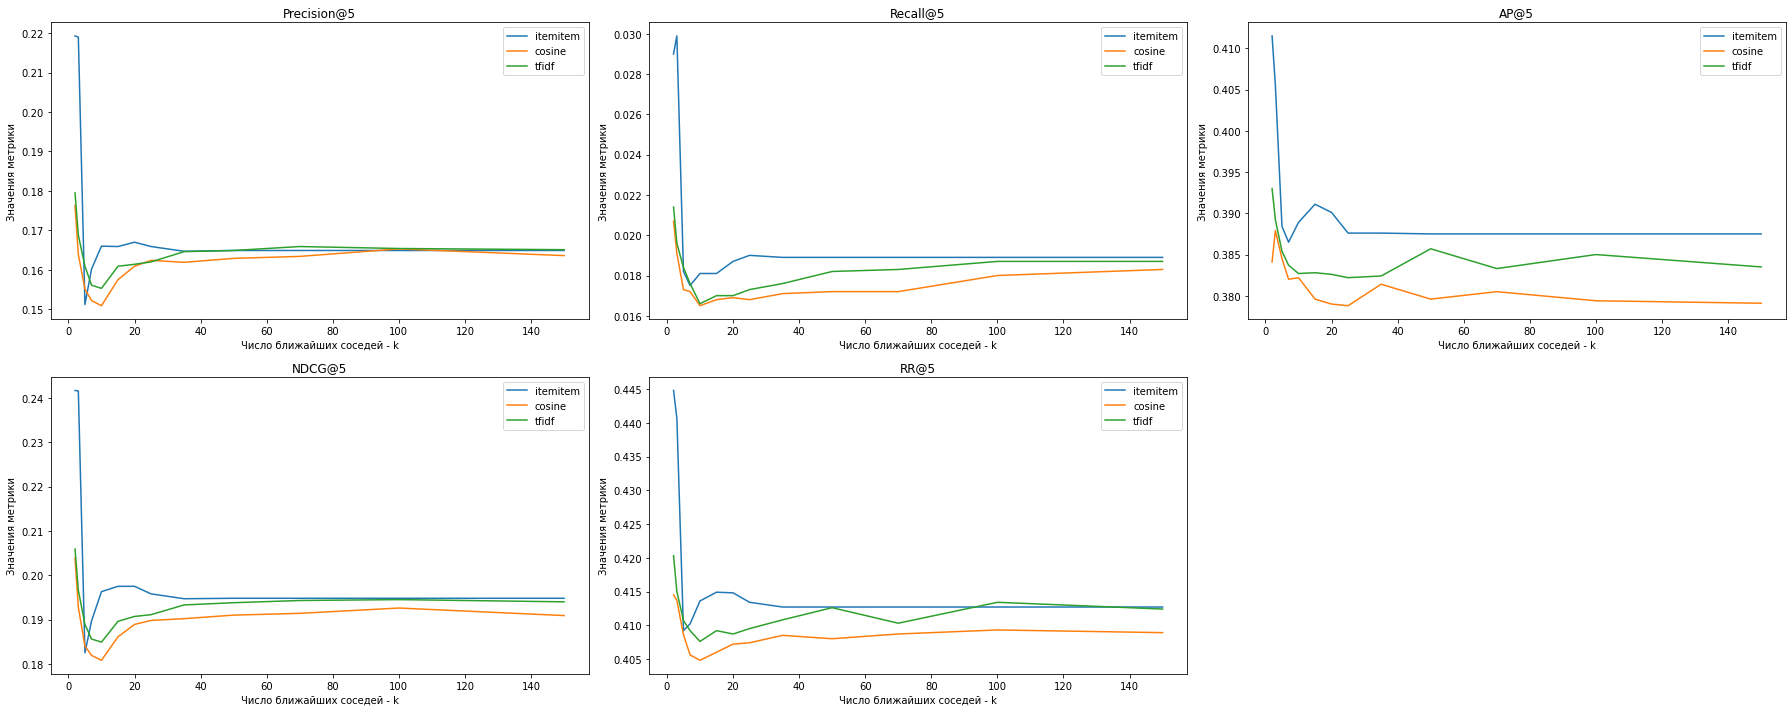

In [143]:
metrics = ['Precision@5', 'Recall@5', 'AP@5', 'NDCG@5', 'RR@5']

fig = plt.figure(figsize=(25, 10))

ax_1 = fig.add_subplot(2, 3, 1)
for alg in recommender_alg:
    ax_1.plot(k_neighbors_list, precision_at_k_dict[alg], label=alg)
ax_1.set_title('Precision@5')
ax_1.legend(loc='upper right')
ax_1.set_xlabel('Число ближайших соседей - k')
ax_1.set_ylabel('Значения метрики')
fig.tight_layout()

ax_2 = fig.add_subplot(2, 3, 2)
for alg in recommender_alg:
    ax_2.plot(k_neighbors_list, recall_at_k_dict[alg], label=alg)
ax_2.set_title('Recall@5')
ax_2.legend(loc='upper right')
ax_2.set_xlabel('Число ближайших соседей - k')
ax_2.set_ylabel('Значения метрики')

ax_3 = fig.add_subplot(2, 3, 3)
for alg in recommender_alg:
    ax_3.plot(k_neighbors_list, ap_at_k_dict[alg], label=alg)
ax_3.set_title('AP@5')
ax_3.legend(loc='upper right')
ax_3.set_xlabel('Число ближайших соседей - k')
ax_3.set_ylabel('Значения метрики')

ax_4 = fig.add_subplot(2, 3, 4)
for alg in recommender_alg:
    ax_4.plot(k_neighbors_list, ndcg_at_k_dict[alg], label=alg)
ax_4.set_title('NDCG@5')
ax_4.legend(loc='upper right')
ax_4.set_xlabel('Число ближайших соседей - k')
ax_4.set_ylabel('Значения метрики')

ax_5 = fig.add_subplot(2, 3, 5)
for alg in recommender_alg:
    ax_5.plot(k_neighbors_list, rr_at_k_dict[alg], label=alg)
ax_5.set_title('RR@5')
ax_5.legend(loc='upper right')
ax_5.set_xlabel('Число ближайших соседей - k')
ax_5.set_ylabel('Значения метрики')

fig.tight_layout()
plt.show()

### Итог по второму подзаданию:
На разных метриках по-разному, но можно заметить, что при рекомендациях по усреднённым 15-20 ближайших соседей результат лучще, чем при 5-ти. Также можем заметить, что ItemIremRecommender всё же в среднем выдаёт лучшие рекомендации.